In [37]:
import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc
import anndata

import torch
from scvi.dataset.dataset import GeneExpressionDataset
from scvi.inference import UnsupervisedTrainer
from scvi.models import SCANVI, VAE
import scipy.io as sio
from scipy.sparse import coo_matrix
import os
from umap import UMAP

PRJ_DIR = "/home/derek/research/Kim-Lab/normalization-simulation/"
OUT_DIR = PRJ_DIR + "exp/exp-14/out/"

In [38]:
file_name = OUT_DIR + 's.cd4.cd8.eff.barcode.csv'
batch_list = pd.read_csv(file_name)
batch_list.columns = ['barcode', 'cell-type']
batch_list = batch_list.replace({'CD4_Memory': 0, 'CD8_Effector': 1})
batch_list

,barcode,cell-type
0,AAACCGTGCCTTTA-1,0
1,AAACGCTGGTGAGG-1,0
2,AAACGGCTTACAGC-1,0
3,AAACTTGAGTGCTA-1,0
4,AAAGACGAGGTTCA-1,0
...,...,...
7409,TTGCATTGGCCTTC-6,1
7410,TTGGAGACTAGCGT-6,1
7411,TTTCACGATTGCGA-6,1
7412,TTTGCATGCACTAG-6,1


In [39]:
file_name = OUT_DIR + 's.cd4.cd8.eff.csv'
counts = pd.read_csv(file_name, index_col=0)
counts

,AAACCGTGCCTTTA.1,AAACGCTGGTGAGG.1,AAACGGCTTACAGC.1,AAACTTGAGTGCTA.1,AAAGACGAGGTTCA.1,AAAGATCTTGACAC.1,AAAGCCTGACTGGT.1,AAAGCCTGCTGACA.1,AAAGCCTGGGAGCA.1,AAAGGCCTGTCATG.1,...,TTCCTAGAGAACTC.6,TTCTACGAGGAAGC.6,TTCTGATGATTTCC.6,TTCTTACTTGAGCT.6,TTGAATGAGGAACG.6,TTGCATTGGCCTTC.6,TTGGAGACTAGCGT.6,TTTCACGATTGCGA.6,TTTGCATGCACTAG.6,TTTGCATGGATAAG.6
AL627309.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AP006222.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RP11.206L10.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RP11.206L10.9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM87B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC011841.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL354822.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KIR2DL2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PNRC2.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [40]:
from scvi.dataset import AnnDatasetFromAnnData
adata = anndata.AnnData(X=counts.T)
adata.obs['group'] = batch_list['cell-type'].to_numpy()
adata.obs['group'] = adata.obs['group'].astype(int)
adata

AnnData object with n_obs × n_vars = 7414 × 16585 
    obs: 'group'

In [41]:
sc.pp.filter_genes(adata, min_cells=5)
adata

AnnData object with n_obs × n_vars = 7414 × 13251 
    obs: 'group'
    var: 'n_cells'

In [42]:
cm = AnnDatasetFromAnnData(adata)
cm

[2020-07-11 16:10:38,389] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-11 16:10:38,390] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-11 16:10:39,231] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-11 16:10:39,322] INFO - scvi.dataset.dataset | Downsampled from 7414 to 7414 cells


GeneExpressionDataset object with n_cells x nb_genes = 7414 x 13251
    gene_attribute_names: 'n_cells', 'gene_names'
    cell_attribute_names: 'batch_indices', 'labels', 'local_vars', 'group', 'local_means'
    cell_categorical_attribute_names: 'labels', 'batch_indices'

In [43]:
n_epochs = 400
n_de = 4000

In [44]:
cm.subsample_genes(n_de)

[2020-07-11 16:10:43,258] INFO - scvi.dataset.dataset | extracting highly variable genes using seurat_v3 flavor


Transforming to str index.


[2020-07-11 16:10:44,230] INFO - scvi.dataset.dataset | Downsampling from 13251 to 4000 genes
[2020-07-11 16:10:44,567] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-11 16:10:44,758] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-11 16:10:45,189] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-11 16:10:45,213] INFO - scvi.dataset.dataset | Downsampled from 7414 to 7414 cells


In [45]:
use_cuda = True

vae = VAE(cm.nb_genes, n_batch=0, n_labels=0,
          n_hidden=128, n_layers=1, n_latent=10, dispersion='gene')

trainer = UnsupervisedTrainer(
    vae, cm,
    train_size=1.0,
    batch_size=128,
    use_cuda=use_cuda,
    n_epochs_kl_warmup=100,
    frequency=10
)

In [46]:
%%time
trainer.train(n_epochs=n_epochs)

[2020-07-11 16:10:49,030] INFO - scvi.inference.inference | KL warmup for 100 epochs



CPU times: user 47min, sys: 32.9 s, total: 47min 33s
Wall time: 5min 56s


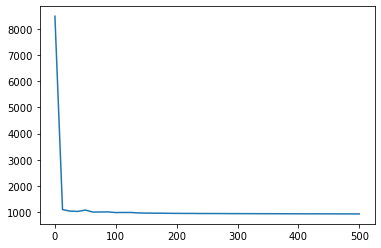

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
elbo_train_set = trainer.history["elbo_train_set"]
x = np.linspace(0, 500, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
# plt.ylim(1150, 1600)

In [48]:
full = trainer.create_posterior(trainer.model,
                                cm, indices=np.arange(len(cm)))

In [78]:
idx1 = adata.obs['group'] == 0
idx2 = adata.obs['group'] == 1
n_samples = 5000
M_permutation = 100000
marker = full.differential_expression_score(idx1, idx2,
                                            n_samples=n_samples,
                                            M_permutation=M_permutation)
np.sum(np.logical_or(marker['bayes_factor'] > 3, marker['bayes_factor'] < -3))

87

In [79]:
marker

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2
LTB,0.9980,0.0020,6.212601,0.006312,0.001158,7.623888,0.421886,0.967791,0.204405,29.395042,1.713668
LDHB,0.9956,0.0044,5.421739,0.002876,0.001058,3.279483,0.950447,0.932226,0.587061,12.771245,4.573442
CD40LG,0.9948,0.0052,5.253881,0.000298,0.000016,0.300453,0.008947,0.239054,0.008259,1.159628,0.036789
FBLN7,0.9860,0.0140,4.254598,0.000099,0.000004,0.049321,0.002753,0.043952,0.002753,0.193180,0.011452
KRT1,0.9822,0.0178,4.010596,0.000354,0.000009,0.088072,0.001376,0.055360,0.001376,0.350793,0.003053
...,...,...,...,...,...,...,...,...,...,...,...
PLEK,0.0008,0.9992,-7.130086,0.000035,0.000635,0.026338,0.530626,0.026338,0.378527,0.108342,2.710319
CTSW,0.0008,0.9992,-7.130086,0.000341,0.002482,0.241067,2.414315,0.195437,0.868548,0.968254,12.456579
PRF1,0.0008,0.9992,-7.130086,0.000063,0.001667,0.056870,1.545079,0.055192,0.679284,0.238519,7.931614
CCL5,0.0006,0.9994,-7.417964,0.000721,0.012645,0.337863,11.721267,0.139238,0.996559,1.416629,60.956188


In [81]:
file_name = OUT_DIR + '2' + "-marker.scvi.cd4.cd8.eff.csv"
if not os.path.isfile(file_name):
    print(f'writing to {file_name}...')
    marker.to_csv(file_name)

writing to /home/derek/research/Kim-Lab/normalization-simulation/exp/exp-14/out/2-marker.scvi.cd4.cd8.eff.csv...


In [82]:
np.sum(np.logical_or(marker['bayes_factor'] > 3, marker['bayes_factor'] < -3))

87

In [83]:
np.sum(marker['bayes_factor'] > 3)

27

In [84]:
np.sum(marker['bayes_factor'] < -3)

60